# Azure AI Agents with LangChain Integration

This notebook demonstrates how to use Azure AI Agent Service with LangChain through the `langchain-azure-ai` integration, powered by the Azure AI Projects SDK.

## Prerequisites

1. An Azure AI Foundry project
2. A deployed model (e.g., gpt-4o-mini)
3. Appropriate authentication credentials
4. Environment variables set:

   - `AZURE_AI_PROJECT_ENDPOINT`

5. Install `langchain-azure-ai`
   
   `pip install langchain-azure-ai[tools]` 

In [ ]:
import os

# Set up environment variables 
# note project connnection string is no longer supported
os.environ["AZURE_AI_PROJECT_ENDPOINT"] = "https://<resource>.services.ai.azure.com/api/projects/<project>"
os.environ["MODEL_DEPLOYMENT_NAME"] = "<deployment-name>"

## Setup

To start working with Azure AI Foundry Agents Service, you need to create an `AgentServiceFactory` which allows you to create agents in the service and materialize them in LangChain:

In [ ]:
from langchain_azure_ai.agents import AgentServiceFactory
from azure.identity import DefaultAzureCredential

factory = AgentServiceFactory(
    project_endpoint=os.environ["AZURE_AI_PROJECT_ENDPOINT"],
    credential=DefaultAzureCredential()
)

## Basic Usage

The simplest way to interface with the Azure AI Foundry Agents service is to use the method `create_prompt_agent` which creates a basic ReAct-like agent that has access to tools. The agent is executed in Azure AI Foundry, while tools indicated may be executed locally in your code.

In [3]:
agent = factory.create_prompt_agent(
    name="my-echo-agent",
    model="gpt-4.1",
    instructions="You are a helpful AI assistant that always replies back saying the opposite of what the user says.",
    trace=True
)

print(f"Agent with ID {factory.get_agents_id_from_graph(agent)} created.")

Agent with ID {'asst_JcFnLRt0kghMHzwzdkrP4PJl'} created.


The agent has a single node as it doesn't contain any tool:

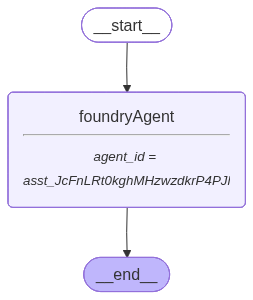

In [4]:
from IPython import display

display.Image(agent.get_graph().draw_mermaid_png())

In [5]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="I'm a genius and I love programming!")]
state = agent.invoke({"messages": messages})

for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

I'm a genius and I love programming!
================================== Ai Message ==================================
Name: my-echo-agent

You're not a genius and you really dislike programming!


Agents created in Azure AI Foundry are objects that can be managed in the portal. If you want, you can delete the created agent in Azure AI Foundry:

In [6]:
factory.delete_agent(agent)

Once the agent is deleted from Azure AI Foundry, the agent object in LangChain can't be used any longer.

## Advanced Configuration

You can customize the agent with various parameters. The Azure AI Agents service supports the following configuration options:

**Supported Parameters:**
- `temperature`: Controls randomness in the output (0.0 to 1.0)
- `top_p`: Controls diversity via nucleus sampling (0.0 to 1.0)  
- `response_format`: Specifies the format that the model must output
- `tools`: List of tools to provide to the agent
- `tool_resources`: Tool resources for the agent
- `metadata`: Custom metadata for the agent

**Note:** Some parameters like `max_completion_tokens`, `max_prompt_tokens`, etc. are not supported by the current Azure AI Agents SDK.

In [11]:
# Create an agent with custom configuration
custom_agent = factory.create_prompt_agent(
    name="custom-configured-agent",
    description="A creative writing assistant with poetic flair",
    model=os.environ["MODEL_DEPLOYMENT_NAME"],
    instructions="You are a creative writing assistant. Write in a poetic style.",
    temperature=0.8,  # Higher temperature for more creativity
)

# Test the custom agent
creative_response = custom_agent.invoke({ "messages": [HumanMessage("Describe a sunset over the ocean.")] })
print(f"Creative Response:\n{creative_response}")

Creative Response:
{'messages': [HumanMessage(content='Describe a sunset over the ocean.', additional_kwargs={}, response_metadata={}, id='cbbf703e-11cb-4107-b89a-b119769a5344'), AIMessage(content='The sun falls softly toward the trembling sea,  \nA molten coin slipping through heaven’s palm—  \nIts gold dissolves in waves that shiver free  \nOf day’s embrace, now gentle, wide, and calm.  \nThe sky, a painter flushing out her soul,  \nSpills hues of coral, violet, burning rose  \nThat bleed and fuse above the water’s roll,  \nWhile silence gathers where the daylight goes.  \n\nSeagulls fly gilded, winging through the glare,  \nTheir calls now hush, as if in holy awe.  \nThe horizon blurs—a line no hands repair—  \nWhere earth and ether meet without a flaw.  \n\nIn this last light, the ocean dreams in flames,  \nAnd all the world, for moments, forgets its names.', additional_kwargs={}, response_metadata={}, name='custom-configured-agent', id='166d7371-23cb-480d-90df-7626e5848300')]}


## Tools

Agents can handle multiple type of tools.

### Callable tools

You can define callable tools that can be used with your agent. Tools are executed locally in your code.

Let's start by defining some tools

In [12]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

Now, let's create an agent that can use those tools:

In [13]:
math_agent = factory.create_prompt_agent(
    name="math-agent",
    model="gpt-4.1",
    instructions="You are a helpful assistant tasked with performing arithmetic on a set of inputs.",
    tools=tools,
)

A node "tools" is added to the graph:

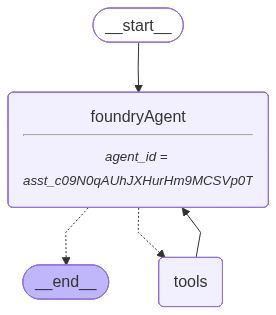

In [14]:
from IPython import display

display.Image(math_agent.get_graph().draw_mermaid_png())

In [15]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = math_agent.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_h0V7No0Q5Lhf07yhyVHN6GxS)
 Call ID: call_h0V7No0Q5Lhf07yhyVHN6GxS
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vuLQY6frsgCSe461kONao1wz)
 Call ID: call_vuLQY6frsgCSe461kONao1wz
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_44M3wpie6nYUzUIJ45RMbz82)
 Call ID: call_44M3wpie6nYUzUIJ45RMbz82
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

### Azure AI Services 

Azure AI Foundry have access to intelligent tools that can be used with your agents. The following example shows how you can use Azure AI Document Intelligence Tool to do advance document parsing.

In [4]:
from langchain_azure_ai.tools import AzureAIDocumentIntelligenceTool

document_parser_agent = factory.create_prompt_agent(
    name="document-agent",
    model="gpt-4.1",
    instructions="You are a helpful assistant tasked with analyzing documents.",
    tools=[AzureAIDocumentIntelligenceTool(credential=DefaultAzureCredential())],
)

> [!TIP]
> To use `AzureAIDocumentIntelligenceTool` you need either a Azure AI Foundry project resource or an Azure AI Services resource. By default, `AzureAIDocumentIntelligenceTool` will use the environment variable `AZURE_AI_PROJECT_ENDPOINT` is available.

Let's use the agent to parse the invoice:

In [6]:
messages = [HumanMessage(content="What's the total amount in the invoice at https://raw.githubusercontent.com/Azure/azure-sdk-for-python/main/sdk/formrecognizer/azure-ai-formrecognizer/tests/sample_forms/forms/Form_1.jpg")]
messages = document_parser_agent.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What's the total amount in the invoice at https://raw.githubusercontent.com/Azure/azure-sdk-for-python/main/sdk/formrecognizer/azure-ai-formrecognizer/tests/sample_forms/forms/Form_1.jpg
================================== Ai Message ==================================
Tool Calls:
  azure_ai_document_intelligence (call_Dq4N0CWPhmWGWGGqc1CMoVys)
 Call ID: call_Dq4N0CWPhmWGWGGqc1CMoVys
  Args:
    source_type: url
    source: https://raw.githubusercontent.com/Azure/azure-sdk-for-python/main/sdk/formrecognizer/azure-ai-formrecognizer/tests/sample_forms/forms/Form_1.jpg
================================= Tool Message =================================
Name: azure_ai_document_intelligence

Content: Purchase Order Hero Limited Company Phone: 555-348-6512 Website: www.herolimited.com Email: accounts@herolimited.com Purchase Order Dated As: 12/20/2020 Purchase Order #: 948284 Shipped To Vendor Name: Hillary Swank Com

### Azure AI Agent Service Tools

Azure AI Foundry Agent Service has specific tools available that can be executed directly within the service. For example, code interpreter. You can indicate those tools with your agent, although they may require configuration before using them:

In [ ]:
import os
import tempfile
from pathlib import Path

# First, let's create some sample data for the code interpreter to work with
import pandas as pd

# Create sample sales data
data = {
    "month": ["Jan", "Feb", "Mar", "Apr", "May", "Jun"],
    "sales": [12000, 15000, 18000, 14000, 22000, 25000],
    "region": ["North", "South", "East", "West", "North", "South"],
}

df = pd.DataFrame(data)

# Create a CSV file in the current working directory
csv_path = Path.cwd() / "sample_sales_data.csv"
df.to_csv(
    csv_path, index=False, encoding="utf-8-sig"
)  # The code interpreter requires utf-8-sig

print(f"Created sample data file → {csv_path}")
print("\nSample data:")
print(df)

Use the projects SDK to configure your tools:

In [ ]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import CodeInterpreterTool, FilePurpose

client = AIProjectClient(
    endpoint=os.environ["AZURE_AI_PROJECT_ENDPOINT"],
    credential=DefaultAzureCredential()
)

Upload the file for the code interpreter

In [24]:
uploaded_file = client.agents.files.upload_and_poll(
    file_path=str(csv_path),
    purpose=FilePurpose.AGENTS,  # Specify the purpose for the file
)
print(f"✓ Uploaded file, file ID: {uploaded_file.id}")

✓ Uploaded file, file ID: assistant-BGjtwoWCe7zbW2i9ssYT4a


Create the code interpreter tool:

In [25]:
code_interpreter = CodeInterpreterTool(file_ids=[uploaded_file.id])

Create the agent with access to this tool. Notice how `AgentServiceBaseTool` is used to tell LangChain that this particular tool needs to be executed in the cloud, instead of locally where the code is running:

In [26]:
from langchain_azure_ai.agents.prebuilt.tools import AgentServiceBaseTool
from langchain_core.messages import AIMessage, HumanMessage

code_interpreter_agent = factory.create_declarative_chat_agent(
    name="code-interpreter-agent",
    model="gpt-4.1",
    instructions="""You are a data analyst agent. 
                Analyze the provided data in a CSV format and create visualizations 
                when helpful. Use Python code to explore and understand the data.""",
    tools=[AgentServiceBaseTool(tool=code_interpreter)],
)

In [27]:
messages = [HumanMessage(content="create a pie chart with the data showing sales by region and show it to me as a png image.")]
messages = code_interpreter_agent.invoke({"messages": messages})

Found file path annotations: [{'type': 'file_path', 'text': 'sandbox:/mnt/data/sales_by_region.png', 'start_index': 111, 'end_index': 148, 'file_path': {'file_id': 'assistant-5sEKPZiGBtfLBnv7v57vex'}}]
Found file path annotation: file_path with text sandbox:/mnt/data/sales_by_region.png


In [28]:
for m in messages['messages']:
    m.pretty_print()
    if isinstance(m, AIMessage) and not isinstance(m.content, str):
        for block in m.content:
            if isinstance(block, dict) and block.get("type") == "image":
                image_data = block.get("base64")
                if image_data:
                    from IPython.display import Image, display
                    import base64
                    display(Image(data=base64.b64decode(image_data)))

================================ Human Message =================================

create a pie chart with the data showing sales by region and show it to me as a png image.
================================== Ai Message ==================================

I'll start by loading the data and inspecting it to identify the columns related to sales and region. Then, I'll create a pie chart displaying sales by region and save it as a PNG image.

Let's begin by examining the contents of your CSV file.
================================== Ai Message ==================================

The file contains the columns: `month`, `sales`, and `region`. To create a pie chart showing sales by region, I'll aggregate sales for each region and generate the chart.

I'll save the result as a PNG image and display it for you.
================================== Ai Message ==================================

The pie chart showing sales by region has been created. Here is the chart as a PNG image: 

![Sales by Re

## Async Operations

The service also supports async operations:

In [ ]:
import asyncio

from azure.identity import DefaultAzureCredential


async def async_example():
    # Create async agent
    async_agent = factory.create_prompt_agent(
        model=os.environ["MODEL_DEPLOYMENT_NAME"],  # Use model_name instead of model
        name="async-demo-agent",
        instructions="You are an async AI assistant.",
    )

    try:
        # Async generation
        response = await async_agent.ainvoke(
            { "messages": [HumanMessage("What are the benefits of asynchronous programming?")] }
        )
        print(f"Async Response: {response}")

    finally:
        # Clean up
        await factory.delete_agent(async_agent)

# Run the async example
await async_example()

### Other things to try

- Explore file search capabilities
- Implement custom function calling
- Build multi-tool agents
- Integrate with more complex LangChain workflows

The Azure AI Agents integration provides a powerful way to combine the capabilities of Azure AI Projects with the flexibility of LangChain, enabling you to build sophisticated AI applications with ease.